# Group 2 Optical Character Recognition Project Project - Group 2
## Summary
This project is to explore creating a character recognition system utilizing a convolutional neural network
## Completed By:
Aidan MacNichol – 30094369

Bailey Collison – 30133909

David Pozniak – 00324580

Yael Gonzalez - 30247278

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.transforms import InterpolationMode
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print('Device name:', torch.cuda.get_device_name(0))
print('Device:', device)

CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Device name: NVIDIA GeForce RTX 2080 Ti
Device: cuda:0


In [2]:
# import torchvision.transforms.functional as F

# def random_skew(img):
#     shear_x = random.uniform(-15, 15)
#     shear_y = random.uniform(-15, 15)
#     return F.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=(shear_x, shear_y))

# def random_resize(img):
#     aug_img_size_h = random.randint(28, 32)
#     aug_img_size_w = random.randint(28, 32)
#     img = F.resize(img, (aug_img_size_h + 1, aug_img_size_w + 1))
#     img = F.crop(img, top=random.randint(0, 1), left=random.randint(0, 1), height=aug_img_size_h, width=aug_img_size_w)
#     return img
    
# def random_color_jitter(img):
#     brightness = random.uniform(0.8, 1.2)
#     contrast = random.uniform(0.8, 1.2)
#     return transforms.functional.adjust_brightness(
#         transforms.functional.adjust_contrast(img, contrast), brightness
#     )

# def random_normalize(img):
#     mean = random.uniform(0.4, 0.6)
#     std = random.uniform(0.4, 0.6)
#     return transforms.functional.normalize(img, [mean], [std])

# augmentation_transform = transforms.Compose([
#     transforms.Pad(padding=5, fill=255),
#     transforms.Lambda(random_skew),
#     transforms.Lambda(random_resize),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.Lambda(random_color_jitter),
#     transforms.ToTensor(),
#     transforms.Lambda(random_normalize),
# ])


# dataset = ImageFolder(root="./data/training_data")
# output_dir = "./data/augmented_training_data"
# os.makedirs(output_dir, exist_ok=True)

# num_augmentations = 5

# for idx in range(len(dataset)):
#     image, label = dataset[idx]
#     class_dir = os.path.join(output_dir, dataset.classes[label])
#     os.makedirs(class_dir, exist_ok=True)
#     for aug_idx in range(num_augmentations):
#         augmented_image = augmentation_transform(image)
#         save_image(augmented_image, os.path.join(class_dir, f"image_{idx}_aug_{aug_idx}.png"))

In [3]:
# Function to compute dataset statistics (same as mnist example)
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        images = data[0]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std
    
# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}
    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    texts.append(text)
                    labels.append(class_name) # label_map[class_name]
    return np.array(texts), np.array(labels)
    
# functions to show an image (also same as mnist example)
def imshow(img,stats):
    # when unnormalizing, I had to add extra channels for RGB
    img = img * stats[1].view(-1, 1, 1) + stats[0].view(-1, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# class EarlyStopper():
#     def __init__(self, patience=3):
#         self.best_val = np.inf
#         self.current_val = np.inf
#         self.patience = patience
#         self.steps_since_last_best = 0
#     def __call__(self, val) -> bool:
#         self.current_val = val
#         self._update_best()
#         if self.steps_since_last_best == self.patience:
#             return True
#         else:
#             return False
#     def _update_best(self):
#         if self.current_val < self.best_val:
#             print(f"New best mse: {self.current_val:.4f}")
#             self.best_val = self.current_val
#             self.steps_since_last_best = 0
#         else:
#             self.steps_since_last_best += 1

class EarlyStopper:
    def __init__(self, patience=3, min_improve=0.001):
        self.best_val = float('inf')
        self.current_val = float('inf')
        self.patience = patience
        self.min_improve = min_improve
        self.steps_since_last_best = 0
        
    def __call__(self, val) -> bool:
        """Returns True if training should stop"""
        self.current_val = val
        self._update_best()
        return self.steps_since_last_best >= self.patience
    
    def _update_best(self):
        """Update best value and patience counter"""
        if self.current_val < (self.best_val - self.min_improve):
            print(f"New best value: {self.current_val:.4f} (improvement > {self.min_improve:.3f})")
            self.best_val = self.current_val
            self.steps_since_last_best = 0
        else:
            self.steps_since_last_best += 1
            print(f"No improvement ({self.steps_since_last_best}/{self.patience})")

def predict(model, dataloader, device, classes):
    model = model.to(device)
    model.eval() 
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    predict_loop = tqdm(dataloader, desc="Predicting", leave=False)
    with torch.no_grad(): 
        for data in predict_loop:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            predict_loop.set_postfix({"batch_acc": f"{torch.sum(preds == labels).item()/labels.size(0):.4f}"})
    all_preds = [classes[pred] for pred in all_preds]
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print(f"Correct: {correct}/{total}")
    return all_preds

In [4]:
batch_size = 1024
image_resize = 28
num_workers = 16

# "./data/training_data"
# "./data/testing_data" 
# "./data/augmented_training_data"
# "./data/all_training_data"
# "./data/license_plate_chars" 
train_folder = "./data/training_data"
test_folder = "./data/testing_data" 

nepochs = 1000
early_stopping_patience = 10
min_improve = 0.01
best_loss = float('inf')
PATH = './best_char_model.pth'

# Extract text + lables
text_train, labels_train = read_text_files_with_labels(train_folder)
text_test, labels_test = read_text_files_with_labels(test_folder)

initial_transform = transforms.Compose([
            transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),  # I was getting an error if I didn't resize
            transforms.Grayscale(num_output_channels=1),       
            transforms.ToTensor()])

train_dataset_initial = torchvision.datasets.ImageFolder(root=train_folder, transform=initial_transform)

train_loader_initial = torch.utils.data.DataLoader(train_dataset_initial, batch_size=batch_size, shuffle=True, num_workers=num_workers)

stats = get_dataset_stats(train_loader_initial)

transform = {
    "train": transforms.Compose([
            transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
            # transforms.RandomCrop(image_resize),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            # transforms.ColorJitter(brightness=0.15, contrast=0.15),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((stats[0]), (stats[1]))]),
    "test": transforms.Compose([
            transforms.Resize((image_resize, image_resize)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((stats[0]), (stats[1]))])
}

# Reload the dataset with the new transform
train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=transform["train"])

train_set_size = int(0.8 * len(train_dataset))
val_set_size = len(train_dataset) - train_set_size

train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(0))

# Load test dataset with same transform
test_dataset = torchvision.datasets.ImageFolder(root=test_folder, transform=transform["test"])

# data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# get classes from folder names
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


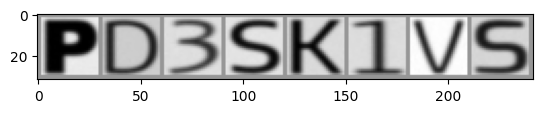

P     D     3     S     K     1     V     S    


In [5]:
# get some random training images and print them
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Flatten the tensor into a 1D vector
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(train_dataset.classes)
print("Number of classes: ", num_classes)

net = Net(num_classes)
net.to(device)

Number of classes:  36


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # Optimizer used for training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
early_stopper = EarlyStopper(patience=early_stopping_patience, min_improve=min_improve)

In [8]:
for epoch in range(nepochs):
    # Training Loop
    train_loss = 0.0
    net.train()
    train_loop = tqdm(trainloader, desc=f"Epoch {epoch + 1}/{nepochs} [Training]", leave=False)
    for i, data in enumerate(train_loop):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loop.set_postfix({"Train Loss": f"{loss.item():.3f}"})
    avg_train_loss = train_loss / len(trainloader)
    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.3f},', end=' ')

    # Validation Loop
    net.eval()
    val_loss = 0.0
    val_loop = tqdm(valloader, desc=f"Epoch {epoch + 1}/{nepochs} [Validation]", leave=False)
    with torch.no_grad():
        for i, data in enumerate(val_loop):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_loop.set_postfix({"Val Loss": f"{loss.item():.3f}"})
    avg_val_loss = val_loss / len(valloader)
    print(f'Val Loss: {avg_val_loss:.3f}')

    if early_stopper(val_loss):
        break
    if early_stopper.steps_since_last_best == 0:
        torch.save(net.state_dict(), PATH)
        
    scheduler.step()
    
print('Finished Training')

Epoch 1, Train Loss: 3.468, 

Val Loss: 3.111
New best value: 15.5527 (improvement > 0.010)


Epoch 2, Train Loss: 1.779, 

Val Loss: 0.912
New best value: 4.5600 (improvement > 0.010)


Epoch 3, Train Loss: 0.646, 

Val Loss: 0.536
New best value: 2.6791 (improvement > 0.010)


Epoch 4, Train Loss: 0.376, 

Val Loss: 0.358
New best value: 1.7908 (improvement > 0.010)


Epoch 5, Train Loss: 0.300, 

Val Loss: 0.288
New best value: 1.4379 (improvement > 0.010)


Epoch 6, Train Loss: 0.267, 

Val Loss: 0.270
New best value: 1.3481 (improvement > 0.010)


Epoch 7, Train Loss: 0.231, 

Val Loss: 0.255
New best value: 1.2732 (improvement > 0.010)


Epoch 8, Train Loss: 0.205, 

Val Loss: 0.227
New best value: 1.1365 (improvement > 0.010)


Epoch 9, Train Loss: 0.195, 

Val Loss: 0.252
No improvement (1/10)


Epoch 10, Train Loss: 0.183, 

Val Loss: 0.215
New best value: 1.0744 (improvement > 0.010)


Epoch 11, Train Loss: 0.176, 

Val Loss: 0.231
No improvement (1/10)


Epoch 12, Train Loss: 0.184, 

Val Loss: 0.256
No improvement (2/10)


Epoch 13, Train Loss: 0.173, 

Val Loss: 0.224
No improvement (3/10)


Epoch 14, Train Loss: 0.156, 

Val Loss: 0.211
New best value: 1.0525 (improvement > 0.010)


Epoch 15, Train Loss: 0.143, 

Val Loss: 0.193
New best value: 0.9637 (improvement > 0.010)


Epoch 16, Train Loss: 0.135, 

Val Loss: 0.200
No improvement (1/10)


Epoch 17, Train Loss: 0.144, 

Val Loss: 0.186
New best value: 0.9278 (improvement > 0.010)


Epoch 18, Train Loss: 0.127, 

Val Loss: 0.195
No improvement (1/10)


Epoch 19, Train Loss: 0.118, 

Val Loss: 0.190
No improvement (2/10)


Epoch 20, Train Loss: 0.110, 

Val Loss: 0.198
No improvement (3/10)


Epoch 21, Train Loss: 0.110, 

Val Loss: 0.196
No improvement (4/10)


Epoch 22, Train Loss: 0.103, 

Val Loss: 0.194
No improvement (5/10)


Epoch 23, Train Loss: 0.100, 

Val Loss: 0.186
No improvement (6/10)


Epoch 24, Train Loss: 0.092, 

Val Loss: 0.199
No improvement (7/10)


Epoch 25, Train Loss: 0.089, 

Val Loss: 0.202
No improvement (8/10)


Epoch 26, Train Loss: 0.094, 

Val Loss: 0.184
No improvement (9/10)


Epoch 27, Train Loss: 0.093, 

Val Loss: 0.195
No improvement (10/10)
Finished Training


In [9]:
# Load the best model to be used in the test set
net = Net(num_classes)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

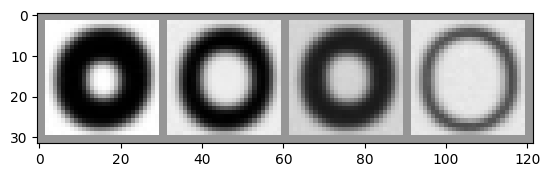

GroundTruth:  0     0     0     0    


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  0     0     0     O    


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 97.32142857142857 %


In [13]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 53.6 %
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Accuracy for class: 5     is 100.0 %
Accuracy for class: 6     is 100.0 %
Accuracy for class: 7     is 100.0 %
Accuracy for class: 8     is 100.0 %
Accuracy for class: 9     is 100.0 %
Accuracy for class: A     is 100.0 %
Accuracy for class: B     is 100.0 %
Accuracy for class: C     is 100.0 %
Accuracy for class: D     is 100.0 %
Accuracy for class: E     is 100.0 %
Accuracy for class: F     is 96.4 %
Accuracy for class: G     is 100.0 %
Accuracy for class: H     is 100.0 %
Accuracy for class: I     is 96.4 %
Accuracy for class: J     is 100.0 %
Accuracy for class: K     is 100.0 %
Accuracy for class: L     is 100.0 %
Accuracy for class: M     is 100.0 %
Accuracy for class: N     is 100.0 %
Accuracy for class: O     is 60.7 %
Accuracy for class: P     is 100.0 %
Accuracy for class: Q     is 100.0 %
Accur


Test Accuracy: 97.32%
Correct: 981/1008


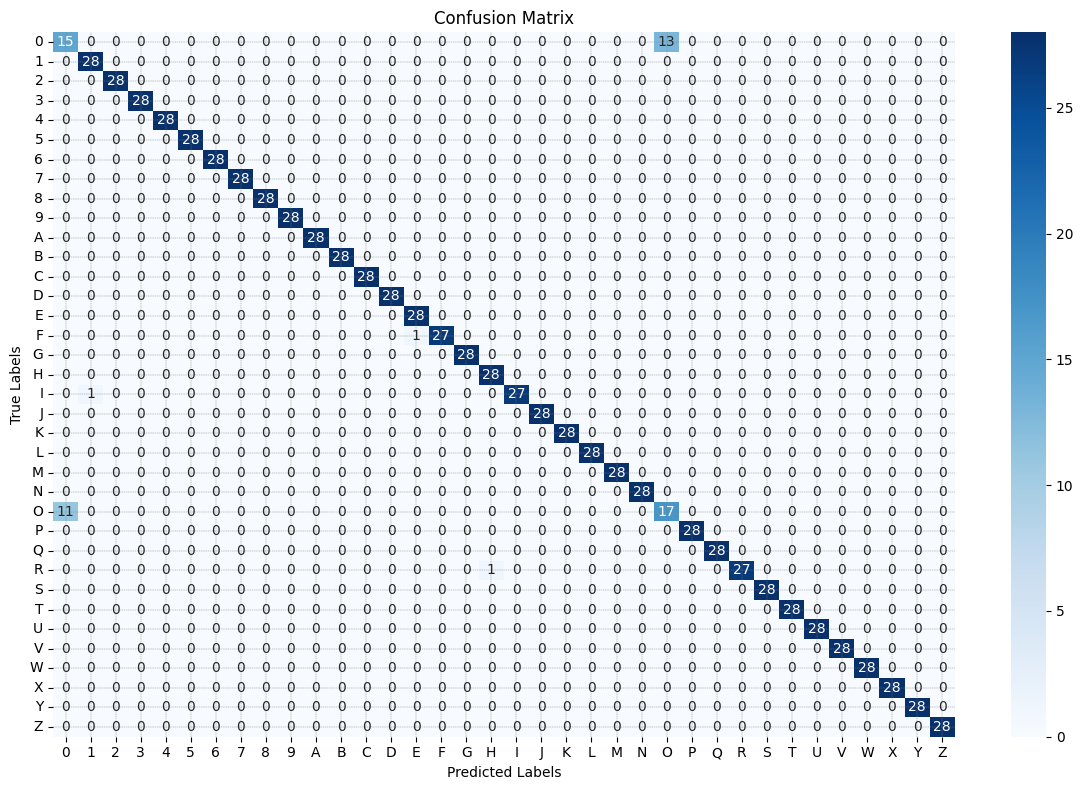

In [14]:
# Evaluation
test_predictions = np.array(predict(net, testloader, device, classes))
    
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True, xticklabels=classes, yticklabels=classes)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.3)
plt.gca().set_yticklabels(classes, rotation=0)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Transfer Learning

## Create Train and Test sets from License Plate Chars data

In [15]:
### NOTE: This should only be ran once. If you dont have the data set split, uncomment and run this.

# # Paths for source and output
# source_dir = "./data/license_plate_chars"
# target_dir = "./data/license_plate_split_data"

# # Ensure target directories exist
# for split in ["train", "test"]:
#     os.makedirs(os.path.join(target_dir, split), exist_ok=True)

# # Process each character folder
# for char in os.listdir(source_dir):
#     char_path = os.path.join(source_dir, char)
#     if not os.path.isdir(char_path):
#         continue  # Skip non-directory files

#     images = os.listdir(char_path)
#     random.shuffle(images)  # Shuffle images

#     num_images = len(images)
#     if num_images < 2:
#         print(f"Skipping '{char}' (not enough images to split)")
#         continue

#     # Ensure at least one image in each split
#     test_count = max(1, int(0.1 * num_images))
#     train_count = num_images - test_count

#     # Create split directories for this character
#     train_path = os.path.join(target_dir, "train", char)
#     test_path = os.path.join(target_dir, "test", char)
#     os.makedirs(train_path, exist_ok=True)
#     os.makedirs(test_path, exist_ok=True)

#     # Copy files
#     for img in images[:train_count]:
#         shutil.copy(os.path.join(char_path, img), os.path.join(train_path, img))
#     for img in images[train_count:]:
#         shutil.copy(os.path.join(char_path, img), os.path.join(test_path, img))

# print("Dataset split complete!")

## Perform the same transformation on the new (license plate) data

In [16]:
PRETRAINED_PATH = "./best_char_model.pth"
PATH = "./best_license_plate_model.pth"

# Dataset paths
train_folder = "./data/license_plate_split_data/train"
test_folder = "./data/license_plate_split_data/test"

## NOTE: When applying transfer learning, the stats from the original model are to be used for normalization, rather then generating new ones on the new data.

# # Initial transform for calculating stats
# initial_transform = transforms.Compose([transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
#                                         transforms.Grayscale(num_output_channels=1),
#                                         transforms.ToTensor()])

# # Load dataset for stats calculation
# train_dataset_initial = torchvision.datasets.ImageFolder(root=train_folder, transform=initial_transform)
# train_loader_initial = torch.utils.data.DataLoader(train_dataset_initial, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# # Calculate stats
# stats = get_dataset_stats(train_loader_initial)

# Define transforms with augmentation for training and simple resize for test
transform = {
    "train": transforms.Compose([
        transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
        # transforms.RandomCrop(image_resize),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=stats[0], std=stats[1])
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((stats[0]), (stats[1]))])
}

# Load datasets with proper transforms
train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=transform["train"])
test_set = torchvision.datasets.ImageFolder(root=test_folder, transform=transform["test"])

## Prepare dataloaders, including Validation set

In [17]:
# Split train into train and validation
train_set_size = int(0.8 * len(train_dataset))
val_set_size = len(train_dataset) - train_set_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(0))

# Create data loaders
dataloaders = {"train": torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
               "val": torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
               "test": torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)}

# Get classes
classes = train_dataset.classes
num_classes = len(classes)
print("Classes:", classes)
print("Number of classes:", num_classes)

print(f"\nDataloaders train set size: {len(dataloaders['train'].dataset)}")
print(f"Dataloaders val set size: {len(dataloaders['val'].dataset)}")
print(f"Dataloaders test set size: {len(dataloaders['test'].dataset)}")

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 36

Dataloaders train set size: 911
Dataloaders val set size: 228
Dataloaders test set size: 106


## Validate train, test, and val sets

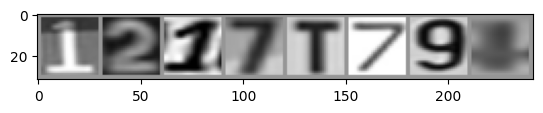

1     2     1     7     T     7     9     1    


In [18]:
# get some random training images and print them
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

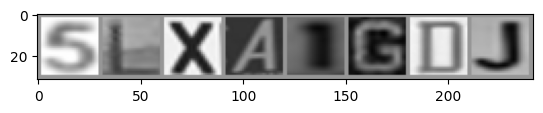

5     L     X     A     1     G     D     J    


In [19]:
# get some random val images and print them (shuffle set to False)
dataiter = iter(dataloaders['val'])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

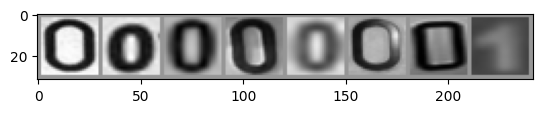

0     0     0     0     0     0     0     1    


In [20]:
# get some test images and print them (shuffle set to False)
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## Prepare transfer learning on new model

In [21]:
# Initialize model
model = Net(num_classes).to(device)

# Load pretrained weights
pretrained_dict = torch.load(PRETRAINED_PATH)
model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# Overwrite entries in the existing state dict
model_dict.update(pretrained_dict)
# Load the new state dict
model.load_state_dict(model_dict)

# Freeze all layers except the final one
for name, param in model.named_parameters():
    if not name.startswith('fc2'):  # Only train the final fully connected layer
        param.requires_grad = False

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc2.parameters(), lr=0.001)
optimizer = optim.SGD(model.fc2.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
early_stopper = EarlyStopper(patience=early_stopping_patience, min_improve=min_improve)

Defining helper functions:

In [22]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=1000, fine_tune=False):
    best_acc = 0.0
    best_loss = float('inf')
    early_stopping_patience = 10
    
    if fine_tune:
        print("\nStarting fine-tuning of all layers...")
        # Unfreeze all layers for fine-tuning
        for param in model.parameters():
            param.requires_grad = True
        # Use smaller learning rate for fine-tuning
        for g in optimizer.param_groups:
            g['lr'] = 0.001
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        epoch_losses = {"train": 0.0, "val": 0.0}
        epoch_accs = {"train": 0.0, "val": 0.0}
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm for progress bar
            phase_loader = tqdm(dataloaders[phase], desc=f"{phase} phase", leave=False)
            for inputs, labels in phase_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                phase_loader.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{torch.sum(preds == labels.data).item()/inputs.size(0):.4f}"
                })

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_losses[phase] = epoch_loss
            epoch_accs[phase] = epoch_acc
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            if phase == "val":
                # Check early stopping criteria
                # if early_stopper(epoch_loss):
                #     print(f"Early stopping triggered at epoch {epoch + 1}")
                #     print(f"Best val loss: {early_stopper.best_val:.4f}")
                #     return model
                
                # if epoch_acc > best_acc:
                #     best_acc = epoch_acc
                #     torch.save(model.state_dict(), PATH)
                #     print(f"New best model saved with val Acc: {best_acc:.4f}")

                if early_stopper(epoch_loss):
                    print(f"Early stopping triggered! Best val: {early_stopper.best_val:.4f}")
                    return model
                    
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), PATH)
                
                # Step the LR scheduler based on validation loss
                scheduler.step(epoch_loss)

    print(f"\nBest val Acc: {early_stopper.best_val:.4f}")
    return model


# Test function
def test_model(model, dataloader, model_path=None):
    if model_path:
        model.load_state_dict(torch.load(model_path))
    model.eval()
    
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        test_loop = tqdm(dataloader, desc="Testing", leave=False)
        for inputs, labels in test_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            test_loop.set_postfix({
                "batch_acc": f"{torch.sum(preds == labels).item()/labels.size(0):.4f}"
            })
    
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    print(f"Correct: {correct}/{total}")
    
    return all_preds, all_labels

## Perform step 1 of transfer learning (frozen output FNN layer)

In [23]:
# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=nepochs)


Epoch 1/1000


train Loss: 3.2064 Acc: 0.5708


val Loss: 3.1867 Acc: 0.5614
New best value: 3.1867 (improvement > 0.010)

Epoch 2/1000


train Loss: 3.0447 Acc: 0.5928


val Loss: 2.9980 Acc: 0.5965
New best value: 2.9980 (improvement > 0.010)

Epoch 3/1000


train Loss: 2.8446 Acc: 0.6301


val Loss: 2.8374 Acc: 0.6184
New best value: 2.8374 (improvement > 0.010)

Epoch 4/1000


train Loss: 2.6950 Acc: 0.6465


val Loss: 2.7314 Acc: 0.6140
New best value: 2.7314 (improvement > 0.010)

Epoch 5/1000


train Loss: 2.6141 Acc: 0.6487


val Loss: 2.6743 Acc: 0.6184
New best value: 2.6743 (improvement > 0.010)

Epoch 6/1000


train Loss: 2.5782 Acc: 0.6312


val Loss: 2.6141 Acc: 0.6096
New best value: 2.6141 (improvement > 0.010)

Epoch 7/1000


train Loss: 2.5186 Acc: 0.6301


val Loss: 2.5331 Acc: 0.6096
New best value: 2.5331 (improvement > 0.010)

Epoch 8/1000


train Loss: 2.4202 Acc: 0.6334


val Loss: 2.4746 Acc: 0.5877
New best value: 2.4746 (improvement > 0.010)

Epoch 9/1000


train Loss: 2.3383 Acc: 0.6312


val Loss: 2.4415 Acc: 0.5614
New best value: 2.4415 (improvement > 0.010)

Epoch 10/1000


train Loss: 2.2737 Acc: 0.6279


val Loss: 2.3892 Acc: 0.5658
New best value: 2.3892 (improvement > 0.010)

Epoch 11/1000


train Loss: 2.1832 Acc: 0.6378


val Loss: 2.3164 Acc: 0.6053
New best value: 2.3164 (improvement > 0.010)

Epoch 12/1000


train Loss: 2.0719 Acc: 0.6674


val Loss: 2.2591 Acc: 0.6009
New best value: 2.2591 (improvement > 0.010)

Epoch 13/1000


train Loss: 1.9782 Acc: 0.6948


val Loss: 2.2417 Acc: 0.6053
New best value: 2.2417 (improvement > 0.010)

Epoch 14/1000


train Loss: 1.9207 Acc: 0.6905


val Loss: 2.2454 Acc: 0.6272
No improvement (1/10)

Epoch 15/1000


train Loss: 1.8753 Acc: 0.6915


val Loss: 2.2385 Acc: 0.6096
No improvement (2/10)

Epoch 16/1000


train Loss: 1.8147 Acc: 0.7014


val Loss: 2.2230 Acc: 0.6228
New best value: 2.2230 (improvement > 0.010)

Epoch 17/1000


train Loss: 1.7494 Acc: 0.7157


val Loss: 2.2152 Acc: 0.6140
No improvement (1/10)

Epoch 18/1000


train Loss: 1.6980 Acc: 0.7322


val Loss: 2.2141 Acc: 0.6053
No improvement (2/10)

Epoch 19/1000


train Loss: 1.6588 Acc: 0.7355


val Loss: 2.2087 Acc: 0.6053
New best value: 2.2087 (improvement > 0.010)

Epoch 20/1000


train Loss: 1.6200 Acc: 0.7234


val Loss: 2.1945 Acc: 0.5965
New best value: 2.1945 (improvement > 0.010)

Epoch 21/1000


train Loss: 1.5760 Acc: 0.7300


val Loss: 2.1769 Acc: 0.5789
New best value: 2.1769 (improvement > 0.010)

Epoch 22/1000


train Loss: 1.5314 Acc: 0.7267


val Loss: 2.1624 Acc: 0.5921
New best value: 2.1624 (improvement > 0.010)

Epoch 23/1000


train Loss: 1.4927 Acc: 0.7344


val Loss: 2.1500 Acc: 0.5965
New best value: 2.1500 (improvement > 0.010)

Epoch 24/1000


train Loss: 1.4586 Acc: 0.7355


val Loss: 2.1368 Acc: 0.6053
New best value: 2.1368 (improvement > 0.010)

Epoch 25/1000


train Loss: 1.4244 Acc: 0.7377


val Loss: 2.1245 Acc: 0.6009
New best value: 2.1245 (improvement > 0.010)

Epoch 26/1000


train Loss: 1.3893 Acc: 0.7442


val Loss: 2.1154 Acc: 0.5877
No improvement (1/10)

Epoch 27/1000


train Loss: 1.3565 Acc: 0.7486


val Loss: 2.1057 Acc: 0.5921
New best value: 2.1057 (improvement > 0.010)

Epoch 28/1000


train Loss: 1.3278 Acc: 0.7519


val Loss: 2.0904 Acc: 0.6053
New best value: 2.0904 (improvement > 0.010)

Epoch 29/1000


train Loss: 1.3023 Acc: 0.7585


val Loss: 2.0685 Acc: 0.6140
New best value: 2.0685 (improvement > 0.010)

Epoch 30/1000


train Loss: 1.2787 Acc: 0.7618


val Loss: 2.0428 Acc: 0.6316
New best value: 2.0428 (improvement > 0.010)

Epoch 31/1000


train Loss: 1.2563 Acc: 0.7618


val Loss: 2.0161 Acc: 0.6360
New best value: 2.0161 (improvement > 0.010)

Epoch 32/1000


train Loss: 1.2338 Acc: 0.7640


val Loss: 1.9911 Acc: 0.6447
New best value: 1.9911 (improvement > 0.010)

Epoch 33/1000


train Loss: 1.2101 Acc: 0.7728


val Loss: 1.9708 Acc: 0.6360
New best value: 1.9708 (improvement > 0.010)

Epoch 34/1000


train Loss: 1.1861 Acc: 0.7794


val Loss: 1.9578 Acc: 0.6316
New best value: 1.9578 (improvement > 0.010)

Epoch 35/1000


train Loss: 1.1639 Acc: 0.7827


val Loss: 1.9512 Acc: 0.6360
No improvement (1/10)

Epoch 36/1000


train Loss: 1.1446 Acc: 0.7805


val Loss: 1.9464 Acc: 0.6404
New best value: 1.9464 (improvement > 0.010)

Epoch 37/1000


train Loss: 1.1266 Acc: 0.7794


val Loss: 1.9393 Acc: 0.6447
No improvement (1/10)

Epoch 38/1000


train Loss: 1.1082 Acc: 0.7859


val Loss: 1.9297 Acc: 0.6579
New best value: 1.9297 (improvement > 0.010)

Epoch 39/1000


train Loss: 1.0897 Acc: 0.7903


val Loss: 1.9196 Acc: 0.6404
New best value: 1.9196 (improvement > 0.010)

Epoch 40/1000


train Loss: 1.0727 Acc: 0.7925


val Loss: 1.9100 Acc: 0.6360
No improvement (1/10)

Epoch 41/1000


train Loss: 1.0575 Acc: 0.7969


val Loss: 1.9011 Acc: 0.6447
New best value: 1.9011 (improvement > 0.010)

Epoch 42/1000


train Loss: 1.0432 Acc: 0.8024


val Loss: 1.8928 Acc: 0.6535
No improvement (1/10)

Epoch 43/1000


train Loss: 1.0294 Acc: 0.8068


val Loss: 1.8850 Acc: 0.6535
New best value: 1.8850 (improvement > 0.010)

Epoch 44/1000


train Loss: 1.0159 Acc: 0.8101


val Loss: 1.8774 Acc: 0.6579
No improvement (1/10)

Epoch 45/1000


train Loss: 1.0028 Acc: 0.8112


val Loss: 1.8687 Acc: 0.6535
New best value: 1.8687 (improvement > 0.010)

Epoch 46/1000


train Loss: 0.9901 Acc: 0.8123


val Loss: 1.8582 Acc: 0.6579
New best value: 1.8582 (improvement > 0.010)

Epoch 47/1000


train Loss: 0.9777 Acc: 0.8145


val Loss: 1.8464 Acc: 0.6667
New best value: 1.8464 (improvement > 0.010)

Epoch 48/1000


train Loss: 0.9660 Acc: 0.8167


val Loss: 1.8346 Acc: 0.6667
New best value: 1.8346 (improvement > 0.010)

Epoch 49/1000


train Loss: 0.9549 Acc: 0.8233


val Loss: 1.8236 Acc: 0.6711
New best value: 1.8236 (improvement > 0.010)

Epoch 50/1000


train Loss: 0.9442 Acc: 0.8277


val Loss: 1.8141 Acc: 0.6798
No improvement (1/10)

Epoch 51/1000


train Loss: 0.9336 Acc: 0.8277


val Loss: 1.8067 Acc: 0.6798
New best value: 1.8067 (improvement > 0.010)

Epoch 52/1000


train Loss: 0.9230 Acc: 0.8310


val Loss: 1.8014 Acc: 0.6754
No improvement (1/10)

Epoch 53/1000


train Loss: 0.9127 Acc: 0.8288


val Loss: 1.7977 Acc: 0.6623
No improvement (2/10)

Epoch 54/1000


train Loss: 0.9029 Acc: 0.8310


val Loss: 1.7944 Acc: 0.6579
New best value: 1.7944 (improvement > 0.010)

Epoch 55/1000


train Loss: 0.8936 Acc: 0.8321


val Loss: 1.7902 Acc: 0.6623
No improvement (1/10)

Epoch 56/1000


train Loss: 0.8845 Acc: 0.8332


val Loss: 1.7845 Acc: 0.6711
No improvement (2/10)

Epoch 57/1000


train Loss: 0.8756 Acc: 0.8364


val Loss: 1.7771 Acc: 0.6711
New best value: 1.7771 (improvement > 0.010)

Epoch 58/1000


train Loss: 0.8669 Acc: 0.8375


val Loss: 1.7686 Acc: 0.6711
No improvement (1/10)

Epoch 59/1000


train Loss: 0.8584 Acc: 0.8397


val Loss: 1.7600 Acc: 0.6711
New best value: 1.7600 (improvement > 0.010)

Epoch 60/1000


train Loss: 0.8501 Acc: 0.8419


val Loss: 1.7519 Acc: 0.6754
No improvement (1/10)

Epoch 61/1000


train Loss: 0.8420 Acc: 0.8452


val Loss: 1.7450 Acc: 0.6754
New best value: 1.7450 (improvement > 0.010)

Epoch 62/1000


train Loss: 0.8342 Acc: 0.8474


val Loss: 1.7394 Acc: 0.6798
No improvement (1/10)

Epoch 63/1000


train Loss: 0.8267 Acc: 0.8496


val Loss: 1.7351 Acc: 0.6798
No improvement (2/10)

Epoch 64/1000


train Loss: 0.8194 Acc: 0.8485


val Loss: 1.7313 Acc: 0.6886
New best value: 1.7313 (improvement > 0.010)

Epoch 65/1000


train Loss: 0.8124 Acc: 0.8496


val Loss: 1.7275 Acc: 0.6930
No improvement (1/10)

Epoch 66/1000


train Loss: 0.8055 Acc: 0.8529


val Loss: 1.7234 Acc: 0.6930
No improvement (2/10)

Epoch 67/1000


train Loss: 0.7987 Acc: 0.8540


val Loss: 1.7188 Acc: 0.6930
New best value: 1.7188 (improvement > 0.010)

Epoch 68/1000


train Loss: 0.7920 Acc: 0.8540


val Loss: 1.7138 Acc: 0.6886
No improvement (1/10)

Epoch 69/1000


train Loss: 0.7856 Acc: 0.8562


val Loss: 1.7088 Acc: 0.6886
No improvement (2/10)

Epoch 70/1000


train Loss: 0.7793 Acc: 0.8573


val Loss: 1.7041 Acc: 0.6842
New best value: 1.7041 (improvement > 0.010)

Epoch 71/1000


train Loss: 0.7733 Acc: 0.8562


val Loss: 1.6997 Acc: 0.6798
No improvement (1/10)

Epoch 72/1000


train Loss: 0.7673 Acc: 0.8573


val Loss: 1.6958 Acc: 0.6798
No improvement (2/10)

Epoch 73/1000


train Loss: 0.7615 Acc: 0.8595


val Loss: 1.6922 Acc: 0.6798
New best value: 1.6922 (improvement > 0.010)

Epoch 74/1000


train Loss: 0.7558 Acc: 0.8595


val Loss: 1.6888 Acc: 0.6930
No improvement (1/10)

Epoch 75/1000


train Loss: 0.7502 Acc: 0.8628


val Loss: 1.6855 Acc: 0.6930
No improvement (2/10)

Epoch 76/1000


train Loss: 0.7447 Acc: 0.8661


val Loss: 1.6822 Acc: 0.6974
New best value: 1.6822 (improvement > 0.010)

Epoch 77/1000


train Loss: 0.7393 Acc: 0.8650


val Loss: 1.6787 Acc: 0.6974
No improvement (1/10)

Epoch 78/1000


train Loss: 0.7340 Acc: 0.8705


val Loss: 1.6753 Acc: 0.6974
No improvement (2/10)

Epoch 79/1000


train Loss: 0.7289 Acc: 0.8705


val Loss: 1.6721 Acc: 0.6930
New best value: 1.6721 (improvement > 0.010)

Epoch 80/1000


train Loss: 0.7239 Acc: 0.8727


val Loss: 1.6690 Acc: 0.6930
No improvement (1/10)

Epoch 81/1000


train Loss: 0.7189 Acc: 0.8749


val Loss: 1.6662 Acc: 0.6974
No improvement (2/10)

Epoch 82/1000


train Loss: 0.7141 Acc: 0.8749


val Loss: 1.6637 Acc: 0.6974
No improvement (3/10)

Epoch 83/1000


train Loss: 0.7093 Acc: 0.8738


val Loss: 1.6614 Acc: 0.6974
New best value: 1.6614 (improvement > 0.010)

Epoch 84/1000


train Loss: 0.7047 Acc: 0.8738


val Loss: 1.6592 Acc: 0.6974
No improvement (1/10)

Epoch 85/1000


train Loss: 0.7001 Acc: 0.8760


val Loss: 1.6570 Acc: 0.6974
No improvement (2/10)

Epoch 86/1000


train Loss: 0.6956 Acc: 0.8760


val Loss: 1.6547 Acc: 0.6974
No improvement (3/10)

Epoch 87/1000


train Loss: 0.6912 Acc: 0.8760


val Loss: 1.6522 Acc: 0.6974
No improvement (4/10)

Epoch 88/1000


train Loss: 0.6869 Acc: 0.8771


val Loss: 1.6495 Acc: 0.6974
New best value: 1.6495 (improvement > 0.010)

Epoch 89/1000


train Loss: 0.6827 Acc: 0.8771


val Loss: 1.6468 Acc: 0.6974
No improvement (1/10)

Epoch 90/1000


train Loss: 0.6785 Acc: 0.8771


val Loss: 1.6441 Acc: 0.6974
No improvement (2/10)

Epoch 91/1000


train Loss: 0.6744 Acc: 0.8793


val Loss: 1.6415 Acc: 0.6974
No improvement (3/10)

Epoch 92/1000


train Loss: 0.6704 Acc: 0.8793


val Loss: 1.6390 Acc: 0.6974
New best value: 1.6390 (improvement > 0.010)

Epoch 93/1000


train Loss: 0.6664 Acc: 0.8793


val Loss: 1.6366 Acc: 0.6974
No improvement (1/10)

Epoch 94/1000


train Loss: 0.6625 Acc: 0.8793


val Loss: 1.6343 Acc: 0.6974
No improvement (2/10)

Epoch 95/1000


train Loss: 0.6587 Acc: 0.8804


val Loss: 1.6320 Acc: 0.6974
No improvement (3/10)

Epoch 96/1000


train Loss: 0.6549 Acc: 0.8804


val Loss: 1.6297 Acc: 0.6974
No improvement (4/10)

Epoch 97/1000


train Loss: 0.6512 Acc: 0.8814


val Loss: 1.6273 Acc: 0.6974
New best value: 1.6273 (improvement > 0.010)

Epoch 98/1000


train Loss: 0.6476 Acc: 0.8825


val Loss: 1.6249 Acc: 0.6974
No improvement (1/10)

Epoch 99/1000


train Loss: 0.6440 Acc: 0.8825


val Loss: 1.6225 Acc: 0.6974
No improvement (2/10)

Epoch 100/1000


train Loss: 0.6404 Acc: 0.8825


val Loss: 1.6201 Acc: 0.6974
No improvement (3/10)

Epoch 101/1000


train Loss: 0.6370 Acc: 0.8836


val Loss: 1.6178 Acc: 0.6974
No improvement (4/10)

Epoch 102/1000


train Loss: 0.6335 Acc: 0.8847


val Loss: 1.6156 Acc: 0.6974
New best value: 1.6156 (improvement > 0.010)

Epoch 103/1000


train Loss: 0.6301 Acc: 0.8858


val Loss: 1.6135 Acc: 0.6974
No improvement (1/10)

Epoch 104/1000


train Loss: 0.6268 Acc: 0.8858


val Loss: 1.6115 Acc: 0.6974
No improvement (2/10)

Epoch 105/1000


train Loss: 0.6235 Acc: 0.8858


val Loss: 1.6095 Acc: 0.6974
No improvement (3/10)

Epoch 106/1000


train Loss: 0.6202 Acc: 0.8858


val Loss: 1.6074 Acc: 0.6974
No improvement (4/10)

Epoch 107/1000


train Loss: 0.6170 Acc: 0.8858


val Loss: 1.6054 Acc: 0.6930
New best value: 1.6054 (improvement > 0.010)

Epoch 108/1000


train Loss: 0.6139 Acc: 0.8858


val Loss: 1.6033 Acc: 0.6886
No improvement (1/10)

Epoch 109/1000


train Loss: 0.6107 Acc: 0.8858


val Loss: 1.6012 Acc: 0.6886
No improvement (2/10)

Epoch 110/1000


train Loss: 0.6077 Acc: 0.8869


val Loss: 1.5992 Acc: 0.6886
No improvement (3/10)

Epoch 111/1000


train Loss: 0.6046 Acc: 0.8880


val Loss: 1.5972 Acc: 0.6886
No improvement (4/10)

Epoch 112/1000


train Loss: 0.6016 Acc: 0.8891


val Loss: 1.5953 Acc: 0.6886
New best value: 1.5953 (improvement > 0.010)

Epoch 113/1000


train Loss: 0.5987 Acc: 0.8891


val Loss: 1.5934 Acc: 0.6930
No improvement (1/10)

Epoch 114/1000


train Loss: 0.5957 Acc: 0.8902


val Loss: 1.5916 Acc: 0.6930
No improvement (2/10)

Epoch 115/1000


train Loss: 0.5928 Acc: 0.8924


val Loss: 1.5899 Acc: 0.6930
No improvement (3/10)

Epoch 116/1000


train Loss: 0.5900 Acc: 0.8924


val Loss: 1.5882 Acc: 0.6930
No improvement (4/10)

Epoch 117/1000


train Loss: 0.5872 Acc: 0.8924


val Loss: 1.5865 Acc: 0.6930
No improvement (5/10)

Epoch 118/1000


train Loss: 0.5844 Acc: 0.8924


val Loss: 1.5847 Acc: 0.6930
New best value: 1.5847 (improvement > 0.010)

Epoch 119/1000


train Loss: 0.5816 Acc: 0.8924


val Loss: 1.5830 Acc: 0.6930
No improvement (1/10)

Epoch 120/1000


train Loss: 0.5789 Acc: 0.8924


val Loss: 1.5812 Acc: 0.6930
No improvement (2/10)

Epoch 121/1000


train Loss: 0.5762 Acc: 0.8935


val Loss: 1.5795 Acc: 0.6974
No improvement (3/10)

Epoch 122/1000


train Loss: 0.5736 Acc: 0.8946


val Loss: 1.5777 Acc: 0.6974
No improvement (4/10)

Epoch 123/1000


train Loss: 0.5710 Acc: 0.8946


val Loss: 1.5760 Acc: 0.6974
No improvement (5/10)

Epoch 124/1000


train Loss: 0.5684 Acc: 0.8946


val Loss: 1.5744 Acc: 0.6974
New best value: 1.5744 (improvement > 0.010)

Epoch 125/1000


train Loss: 0.5658 Acc: 0.8957


val Loss: 1.5728 Acc: 0.6974
No improvement (1/10)

Epoch 126/1000


train Loss: 0.5633 Acc: 0.8957


val Loss: 1.5712 Acc: 0.6974
No improvement (2/10)

Epoch 127/1000


train Loss: 0.5608 Acc: 0.8968


val Loss: 1.5697 Acc: 0.6974
No improvement (3/10)

Epoch 128/1000


train Loss: 0.5583 Acc: 0.8979


val Loss: 1.5681 Acc: 0.6974
No improvement (4/10)

Epoch 129/1000


train Loss: 0.5558 Acc: 0.8990


val Loss: 1.5666 Acc: 0.6974
No improvement (5/10)

Epoch 130/1000


train Loss: 0.5534 Acc: 0.8990


val Loss: 1.5651 Acc: 0.6974
No improvement (6/10)

Epoch 131/1000


train Loss: 0.5510 Acc: 0.8990


val Loss: 1.5636 Acc: 0.6974
New best value: 1.5636 (improvement > 0.010)

Epoch 132/1000


train Loss: 0.5486 Acc: 0.9012


val Loss: 1.5621 Acc: 0.6886
No improvement (1/10)

Epoch 133/1000


train Loss: 0.5463 Acc: 0.9012


val Loss: 1.5606 Acc: 0.6886
No improvement (2/10)

Epoch 134/1000


train Loss: 0.5439 Acc: 0.9034


val Loss: 1.5591 Acc: 0.6886
No improvement (3/10)

Epoch 135/1000


train Loss: 0.5416 Acc: 0.9034


val Loss: 1.5577 Acc: 0.6930
No improvement (4/10)

Epoch 136/1000


train Loss: 0.5394 Acc: 0.9034


val Loss: 1.5563 Acc: 0.6930
No improvement (5/10)

Epoch 137/1000


train Loss: 0.5371 Acc: 0.9034


val Loss: 1.5549 Acc: 0.6930
No improvement (6/10)

Epoch 138/1000


train Loss: 0.5349 Acc: 0.9034


val Loss: 1.5535 Acc: 0.6930
New best value: 1.5535 (improvement > 0.010)

Epoch 139/1000


train Loss: 0.5327 Acc: 0.9034


val Loss: 1.5522 Acc: 0.6930
No improvement (1/10)

Epoch 140/1000


train Loss: 0.5305 Acc: 0.9034


val Loss: 1.5508 Acc: 0.6930
No improvement (2/10)

Epoch 141/1000


train Loss: 0.5283 Acc: 0.9056


val Loss: 1.5495 Acc: 0.6930
No improvement (3/10)

Epoch 142/1000


train Loss: 0.5262 Acc: 0.9056


val Loss: 1.5482 Acc: 0.6930
No improvement (4/10)

Epoch 143/1000


train Loss: 0.5241 Acc: 0.9067


val Loss: 1.5469 Acc: 0.6930
No improvement (5/10)

Epoch 144/1000


train Loss: 0.5220 Acc: 0.9067


val Loss: 1.5456 Acc: 0.6930
No improvement (6/10)

Epoch 145/1000


train Loss: 0.5199 Acc: 0.9067


val Loss: 1.5443 Acc: 0.6930
No improvement (7/10)

Epoch 146/1000


train Loss: 0.5179 Acc: 0.9067


val Loss: 1.5431 Acc: 0.6930
New best value: 1.5431 (improvement > 0.010)

Epoch 147/1000


train Loss: 0.5158 Acc: 0.9067


val Loss: 1.5419 Acc: 0.6930
No improvement (1/10)

Epoch 148/1000


train Loss: 0.5138 Acc: 0.9078


val Loss: 1.5407 Acc: 0.6930
No improvement (2/10)

Epoch 149/1000


train Loss: 0.5118 Acc: 0.9089


val Loss: 1.5395 Acc: 0.6930
No improvement (3/10)

Epoch 150/1000


train Loss: 0.5098 Acc: 0.9100


val Loss: 1.5384 Acc: 0.6930
No improvement (4/10)

Epoch 151/1000


train Loss: 0.5079 Acc: 0.9100


val Loss: 1.5372 Acc: 0.6974
No improvement (5/10)

Epoch 152/1000


train Loss: 0.5060 Acc: 0.9100


val Loss: 1.5361 Acc: 0.6974
No improvement (6/10)

Epoch 153/1000


train Loss: 0.5040 Acc: 0.9100


val Loss: 1.5350 Acc: 0.6974
No improvement (7/10)

Epoch 154/1000


train Loss: 0.5021 Acc: 0.9100


val Loss: 1.5339 Acc: 0.6974
No improvement (8/10)

Epoch 155/1000


train Loss: 0.5002 Acc: 0.9111


val Loss: 1.5328 Acc: 0.6974
New best value: 1.5328 (improvement > 0.010)

Epoch 156/1000


train Loss: 0.4984 Acc: 0.9122


val Loss: 1.5318 Acc: 0.6974
No improvement (1/10)

Epoch 157/1000


train Loss: 0.4965 Acc: 0.9133


val Loss: 1.5307 Acc: 0.6974
No improvement (2/10)

Epoch 158/1000


train Loss: 0.4947 Acc: 0.9133


val Loss: 1.5297 Acc: 0.6974
No improvement (3/10)

Epoch 159/1000


train Loss: 0.4929 Acc: 0.9133


val Loss: 1.5288 Acc: 0.6974
No improvement (4/10)

Epoch 160/1000


train Loss: 0.4911 Acc: 0.9144


val Loss: 1.5278 Acc: 0.6974
No improvement (5/10)

Epoch 161/1000


train Loss: 0.4893 Acc: 0.9144


val Loss: 1.5268 Acc: 0.6974
No improvement (6/10)

Epoch 162/1000


train Loss: 0.4875 Acc: 0.9144


val Loss: 1.5259 Acc: 0.6974
No improvement (7/10)

Epoch 163/1000


train Loss: 0.4858 Acc: 0.9144


val Loss: 1.5250 Acc: 0.6974
No improvement (8/10)

Epoch 164/1000


train Loss: 0.4840 Acc: 0.9144


val Loss: 1.5240 Acc: 0.6974
No improvement (9/10)

Epoch 165/1000


train Loss: 0.4823 Acc: 0.9144


val Loss: 1.5231 Acc: 0.6974
No improvement (10/10)
Early stopping triggered! Best val: 1.5328



Test Accuracy: 66.98%
Correct: 71/106


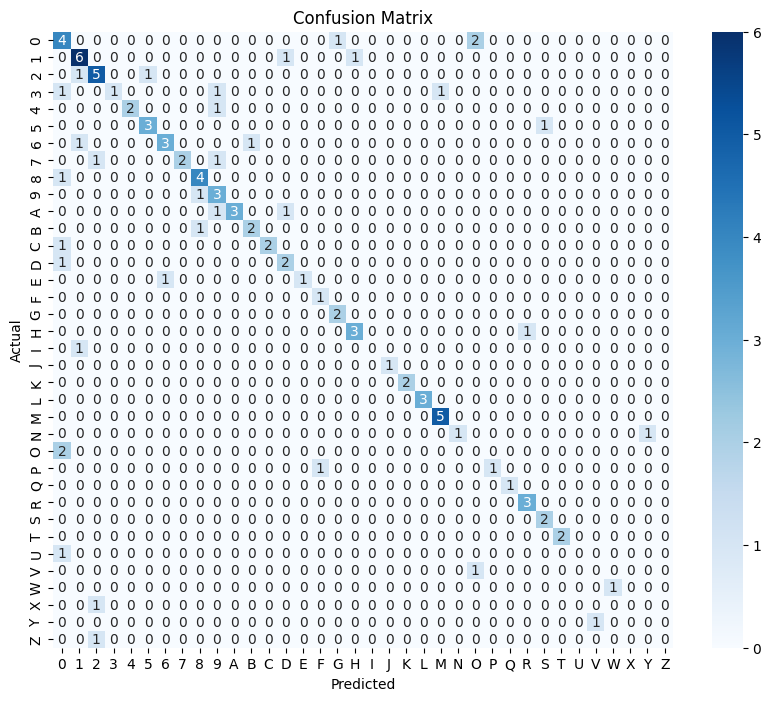

In [24]:
# Evaluate the model on the test set
preds, labels = test_model(model, dataloaders["test"])

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Perform step 2 of transfer learning (unfreeze and train all layers with a small learning rate)


Starting fine-tuning of all layers...

Epoch 1/1000


train Loss: 0.4806 Acc: 0.9155


val Loss: 1.5199 Acc: 0.6974
New best value: 1.5199 (improvement > 0.010)

Epoch 2/1000


train Loss: 0.4780 Acc: 0.9155


val Loss: 1.5139 Acc: 0.7018
No improvement (1/10)

Epoch 3/1000


train Loss: 0.4735 Acc: 0.9155


val Loss: 1.5058 Acc: 0.7061
New best value: 1.5058 (improvement > 0.010)

Epoch 4/1000


train Loss: 0.4677 Acc: 0.9177


val Loss: 1.4960 Acc: 0.7061
No improvement (1/10)

Epoch 5/1000


train Loss: 0.4613 Acc: 0.9199


val Loss: 1.4847 Acc: 0.7018
New best value: 1.4847 (improvement > 0.010)

Epoch 6/1000


train Loss: 0.4546 Acc: 0.9199


val Loss: 1.4722 Acc: 0.7061
New best value: 1.4722 (improvement > 0.010)

Epoch 7/1000


train Loss: 0.4481 Acc: 0.9232


val Loss: 1.4595 Acc: 0.7105
New best value: 1.4595 (improvement > 0.010)

Epoch 8/1000


train Loss: 0.4418 Acc: 0.9254


val Loss: 1.4474 Acc: 0.7149
New best value: 1.4474 (improvement > 0.010)

Epoch 9/1000


train Loss: 0.4359 Acc: 0.9254


val Loss: 1.4360 Acc: 0.7193
New best value: 1.4360 (improvement > 0.010)

Epoch 10/1000


train Loss: 0.4301 Acc: 0.9243


val Loss: 1.4258 Acc: 0.7193
New best value: 1.4258 (improvement > 0.010)

Epoch 11/1000


train Loss: 0.4245 Acc: 0.9232


val Loss: 1.4171 Acc: 0.7237
No improvement (1/10)

Epoch 12/1000


train Loss: 0.4191 Acc: 0.9265


val Loss: 1.4098 Acc: 0.7237
New best value: 1.4098 (improvement > 0.010)

Epoch 13/1000


train Loss: 0.4140 Acc: 0.9254


val Loss: 1.4042 Acc: 0.7237
No improvement (1/10)

Epoch 14/1000


train Loss: 0.4089 Acc: 0.9265


val Loss: 1.3989 Acc: 0.7237
New best value: 1.3989 (improvement > 0.010)

Epoch 15/1000


train Loss: 0.4039 Acc: 0.9265


val Loss: 1.3940 Acc: 0.7237
No improvement (1/10)

Epoch 16/1000


train Loss: 0.3991 Acc: 0.9276


val Loss: 1.3893 Acc: 0.7237
No improvement (2/10)

Epoch 17/1000


train Loss: 0.3943 Acc: 0.9308


val Loss: 1.3848 Acc: 0.7237
New best value: 1.3848 (improvement > 0.010)

Epoch 18/1000


train Loss: 0.3895 Acc: 0.9319


val Loss: 1.3807 Acc: 0.7237
No improvement (1/10)

Epoch 19/1000


train Loss: 0.3847 Acc: 0.9319


val Loss: 1.3771 Acc: 0.7237
No improvement (2/10)

Epoch 20/1000


train Loss: 0.3800 Acc: 0.9319


val Loss: 1.3742 Acc: 0.7237
New best value: 1.3742 (improvement > 0.010)

Epoch 21/1000


train Loss: 0.3753 Acc: 0.9330


val Loss: 1.3718 Acc: 0.7237
No improvement (1/10)

Epoch 22/1000


train Loss: 0.3707 Acc: 0.9319


val Loss: 1.3698 Acc: 0.7237
No improvement (2/10)

Epoch 23/1000


train Loss: 0.3661 Acc: 0.9308


val Loss: 1.3681 Acc: 0.7325
No improvement (3/10)

Epoch 24/1000


train Loss: 0.3616 Acc: 0.9341


val Loss: 1.3667 Acc: 0.7368
No improvement (4/10)

Epoch 25/1000


train Loss: 0.3571 Acc: 0.9352


val Loss: 1.3654 Acc: 0.7368
No improvement (5/10)

Epoch 26/1000


train Loss: 0.3528 Acc: 0.9352


val Loss: 1.3641 Acc: 0.7325
New best value: 1.3641 (improvement > 0.010)

Epoch 27/1000


train Loss: 0.3486 Acc: 0.9363


val Loss: 1.3627 Acc: 0.7325
No improvement (1/10)

Epoch 28/1000


train Loss: 0.3444 Acc: 0.9396


val Loss: 1.3614 Acc: 0.7325
No improvement (2/10)

Epoch 29/1000


train Loss: 0.3403 Acc: 0.9407


val Loss: 1.3604 Acc: 0.7325
No improvement (3/10)

Epoch 30/1000


train Loss: 0.3364 Acc: 0.9418


val Loss: 1.3595 Acc: 0.7325
No improvement (4/10)

Epoch 31/1000


train Loss: 0.3326 Acc: 0.9429


val Loss: 1.3587 Acc: 0.7368
No improvement (5/10)

Epoch 32/1000


train Loss: 0.3288 Acc: 0.9429


val Loss: 1.3580 Acc: 0.7368
No improvement (6/10)

Epoch 33/1000


train Loss: 0.3252 Acc: 0.9451


val Loss: 1.3571 Acc: 0.7412
No improvement (7/10)

Epoch 34/1000


train Loss: 0.3216 Acc: 0.9451


val Loss: 1.3560 Acc: 0.7412
No improvement (8/10)

Epoch 35/1000


train Loss: 0.3181 Acc: 0.9451


val Loss: 1.3548 Acc: 0.7412
No improvement (9/10)

Epoch 36/1000


train Loss: 0.3147 Acc: 0.9451


val Loss: 1.3533 Acc: 0.7412
New best value: 1.3533 (improvement > 0.010)

Epoch 37/1000


train Loss: 0.3113 Acc: 0.9462


val Loss: 1.3516 Acc: 0.7456
No improvement (1/10)

Epoch 38/1000


train Loss: 0.3080 Acc: 0.9462


val Loss: 1.3500 Acc: 0.7456
No improvement (2/10)

Epoch 39/1000


train Loss: 0.3047 Acc: 0.9462


val Loss: 1.3485 Acc: 0.7456
No improvement (3/10)

Epoch 40/1000


train Loss: 0.3016 Acc: 0.9473


val Loss: 1.3473 Acc: 0.7456
No improvement (4/10)

Epoch 41/1000


train Loss: 0.2985 Acc: 0.9484


val Loss: 1.3462 Acc: 0.7456
No improvement (5/10)

Epoch 42/1000


train Loss: 0.2955 Acc: 0.9484


val Loss: 1.3454 Acc: 0.7456
No improvement (6/10)

Epoch 43/1000


train Loss: 0.2925 Acc: 0.9506


val Loss: 1.3447 Acc: 0.7456
No improvement (7/10)

Epoch 44/1000


train Loss: 0.2895 Acc: 0.9539


val Loss: 1.3439 Acc: 0.7456
No improvement (8/10)

Epoch 45/1000


train Loss: 0.2866 Acc: 0.9539


val Loss: 1.3429 Acc: 0.7456
New best value: 1.3429 (improvement > 0.010)

Epoch 46/1000


train Loss: 0.2838 Acc: 0.9550


val Loss: 1.3415 Acc: 0.7456
No improvement (1/10)

Epoch 47/1000


train Loss: 0.2810 Acc: 0.9561


val Loss: 1.3398 Acc: 0.7456
No improvement (2/10)

Epoch 48/1000


train Loss: 0.2783 Acc: 0.9583


val Loss: 1.3379 Acc: 0.7456
No improvement (3/10)

Epoch 49/1000


train Loss: 0.2756 Acc: 0.9583


val Loss: 1.3359 Acc: 0.7456
No improvement (4/10)

Epoch 50/1000


train Loss: 0.2729 Acc: 0.9572


val Loss: 1.3339 Acc: 0.7456
No improvement (5/10)

Epoch 51/1000


train Loss: 0.2703 Acc: 0.9594


val Loss: 1.3321 Acc: 0.7456
New best value: 1.3321 (improvement > 0.010)

Epoch 52/1000


train Loss: 0.2677 Acc: 0.9594


val Loss: 1.3305 Acc: 0.7456
No improvement (1/10)

Epoch 53/1000


train Loss: 0.2652 Acc: 0.9605


val Loss: 1.3292 Acc: 0.7456
No improvement (2/10)

Epoch 54/1000


train Loss: 0.2627 Acc: 0.9616


val Loss: 1.3281 Acc: 0.7456
No improvement (3/10)

Epoch 55/1000


train Loss: 0.2602 Acc: 0.9627


val Loss: 1.3272 Acc: 0.7456
No improvement (4/10)

Epoch 56/1000


train Loss: 0.2578 Acc: 0.9616


val Loss: 1.3264 Acc: 0.7456
No improvement (5/10)

Epoch 57/1000


train Loss: 0.2554 Acc: 0.9616


val Loss: 1.3257 Acc: 0.7456
No improvement (6/10)

Epoch 58/1000


train Loss: 0.2531 Acc: 0.9616


val Loss: 1.3250 Acc: 0.7456
No improvement (7/10)

Epoch 59/1000


train Loss: 0.2508 Acc: 0.9627


val Loss: 1.3245 Acc: 0.7456
No improvement (8/10)

Epoch 60/1000


train Loss: 0.2485 Acc: 0.9627


val Loss: 1.3239 Acc: 0.7456
No improvement (9/10)

Epoch 61/1000


train Loss: 0.2463 Acc: 0.9627


val Loss: 1.3234 Acc: 0.7456
No improvement (10/10)
Early stopping triggered! Best val: 1.3321

Final evaluation after fine-tuning:



Test Accuracy: 72.64%
Correct: 77/106


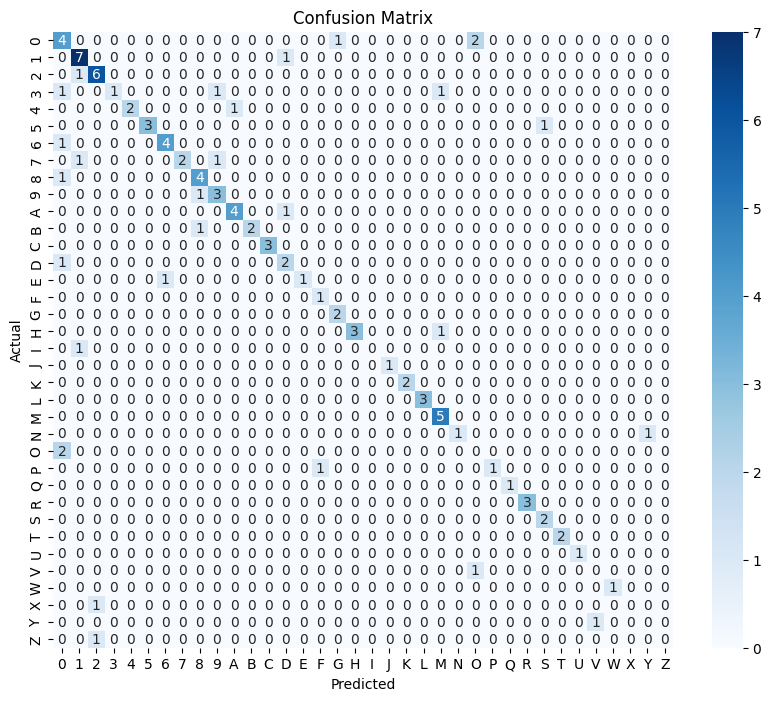

In [25]:
early_stopper = EarlyStopper(patience=early_stopping_patience, min_improve=min_improve)

# Initial transform for calculating stats
initial_transform = transforms.Compose([transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
                                        transforms.Grayscale(num_output_channels=1),
                                        transforms.ToTensor()])

# Load dataset for stats calculation
train_dataset_initial = torchvision.datasets.ImageFolder(root=train_folder, transform=initial_transform)
train_loader_initial = torch.utils.data.DataLoader(train_dataset_initial, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Calculate stats
stats_license_place = get_dataset_stats(train_loader_initial)

# Define transforms with augmentation for training and simple resize for test
transform = {
    "train": transforms.Compose([
        transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
        # transforms.RandomCrop(image_resize),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        # transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=stats_license_place[0], std=stats_license_place[1])
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((stats_license_place[0]), (stats_license_place[1]))])
}

# Load datasets with proper transforms
train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=transform["train"])
test_set = torchvision.datasets.ImageFolder(root=test_folder, transform=transform["test"])


# Fine-tuning (train all layers)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)  # New optimizer for all parameters
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=nepochs, fine_tune=True)

# Final evaluation after fine-tuning
print("\nFinal evaluation after fine-tuning:")
all_preds, all_labels = test_model(model, dataloaders["test"], PATH)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Do some more evaluations:

In [26]:
PATH

'./best_license_plate_model.pth'

In [27]:
net = Net(num_classes)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

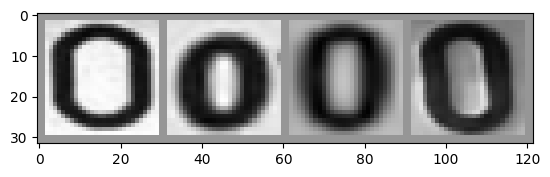

GroundTruth:  0     0     0     0    


In [28]:
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)

In [29]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  0     O     0     O    


In [30]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 89.3 %
Accuracy for class: 1     is 96.4 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 85.7 %
Accuracy for class: 4     is 96.4 %
Accuracy for class: 5     is 89.3 %
Accuracy for class: 6     is 100.0 %
Accuracy for class: 7     is 100.0 %
Accuracy for class: 8     is 100.0 %
Accuracy for class: 9     is 100.0 %
Accuracy for class: A     is 92.9 %
Accuracy for class: B     is 100.0 %
Accuracy for class: C     is 96.4 %
Accuracy for class: D     is 100.0 %
Accuracy for class: E     is 85.7 %
Accuracy for class: F     is 78.6 %
Accuracy for class: G     is 96.4 %
Accuracy for class: H     is 96.4 %
Accuracy for class: I     is 42.9 %
Accuracy for class: J     is 53.6 %
Accuracy for class: K     is 96.4 %
Accuracy for class: L     is 92.9 %
Accuracy for class: M     is 100.0 %
Accuracy for class: N     is 96.4 %
Accuracy for class: O     is 7.1 %
Accuracy for class: P     is 96.4 %
Accuracy for class: Q     is 67.9 %
Accuracy for class: R